(HW7)=
# HW7

**Deadline (hard only!)**: 24.04.2024 11:59 (GMT+5).

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imread
from skimage.transform import resize
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from glob import glob
%config InlineBackend.figure_format = 'svg'

def load_notmnist(path='./notMNIST_small',letters='ABCDEFGHIJ',
                  img_shape=(28,28),test_size=0.25,one_hot=False):

    # download data if it's missing. If you have any problems, go to the urls and load it manually.
    if not os.path.exists(path):
        print("Downloading data...")
        assert os.system('curl http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz > notMNIST_small.tar.gz') == 0
        print("Extracting ...")
        assert os.system('tar -zxvf notMNIST_small.tar.gz > untar_notmnist.log') == 0

    data,labels = [],[]
    print("Parsing...")
    for img_path in glob(os.path.join(path,'*/*')):
        class_i = img_path.split(os.sep)[-2]
        if class_i not in letters:
            continue
        try:
            data.append(resize(imread(img_path), img_shape))
            labels.append(class_i,)
        except:
            print("found broken img: %s [it's ok if <10 images are broken]" % img_path)

    data = np.stack(data)[:,None].astype('float32')
    data = (data - np.mean(data)) / np.std(data)

    #convert classes to ints
    letter_to_i = {l:i for i,l in enumerate(letters)}
    labels = np.array(list(map(letter_to_i.get, labels)))

    if one_hot:
        labels = (np.arange(np.max(labels) + 1)[None,:] == labels[:, None]).astype('float32')

    #split into train/test
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, stratify=labels)

    print("Done")
    return X_train, y_train, X_test, y_test

## Task description

In this notebook you are suggested to train several models of machine learning on the notMNIST dataset. To get full points per each model it must beat the **baseline** on test dataset. Models to test:

* logistic regression, 86% (**1 point**)
* k-nearest neigbors, 88% (**1 point**)
* MLP, 91% (**1 point**)
* CNN, 92% (**1.5 points**)
* overall comparison of models, including some graphs (e.g, bar plot) (**0.5 points**)

### Important notes

* The total time of execution of all cells must not exceed $10$ minutes
* Broken code in a section automatically implies $0$ points for this section
* Do not erase any existing cells
* Use magic cell %%time to measure the time of execution of heavy-computation cells
* For each model use the followind structure:
    1. Import and build model

    2. Fit model on train dataset

    3. Measure and print train and test accuracy

    4. Make predictions on test dataset

    5. Plot confusion matrix

    6. Plot 16 random samples from the test dataset with true labels and predicted classes
    
    7. Try different hyperparameters, plot graphs of accuracy vs most important parameters

## Load `notmnist` dataset

In [20]:
%%time
X_train, y_train, X_test, y_test = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

Parsing...
found broken img: ./notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small\F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done
CPU times: total: 7.53 s
Wall time: 8.94 s


Size of train and test datasets:

In [3]:
X_train.shape, X_test.shape

((14043, 784), (4681, 784))

Verify that the classes are balanced:

In [4]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1404, 1404, 1405, 1405, 1405, 1404, 1404, 1404, 1404, 1404],
       dtype=int64))

## Visualize some data

In [5]:
def plot_letters(X, y_true, y_pred=None, n=4, random_state=123):
    np.random.seed(random_state)
    indices = np.random.choice(np.arange(X.shape[0]), size=n*n, replace=False)
    plt.figure(figsize=(10, 10))
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[indices[i]].reshape(28, 28), cmap='gray')
        # plt.imshow(train_images[i], cmap=plt.cm.binary)
        if y_pred is None:
            title = chr(ord("A") + y_true[indices[i]])
        else:
            title = f"y={chr(ord('A') + y_true[indices[i]])}, ŷ={chr(ord('A') + y_pred[indices[i]])}"
        plt.title(title, size=20)
    plt.show()

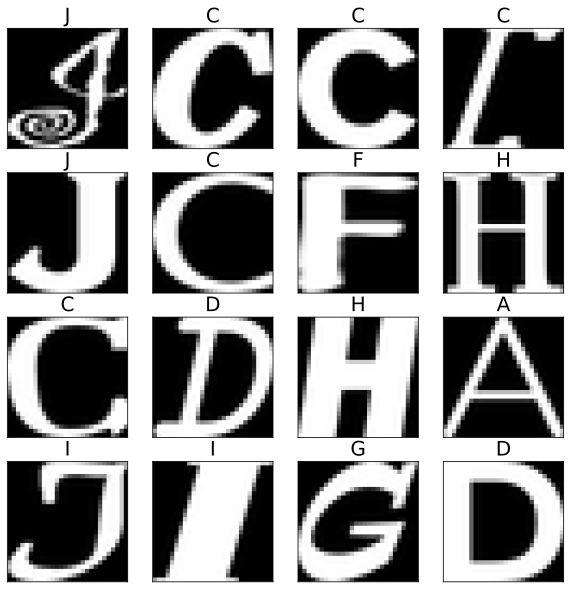

In [6]:
plot_letters(X_train, y_train, random_state=912)

## Logistic regression

**Hyperparameters**:
* regularization type (`penalty`)
* regularization constant ($C$)
* `max_iter`

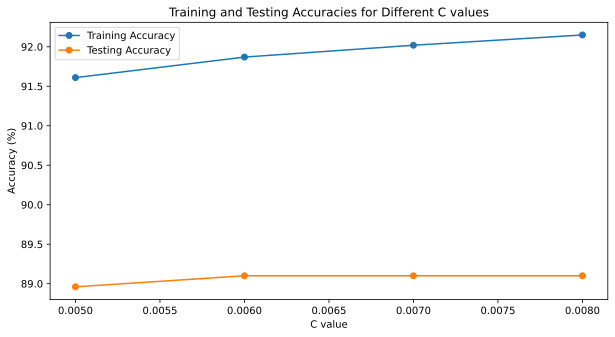

The best C value is: 0.006 test_accuracy: 89.1


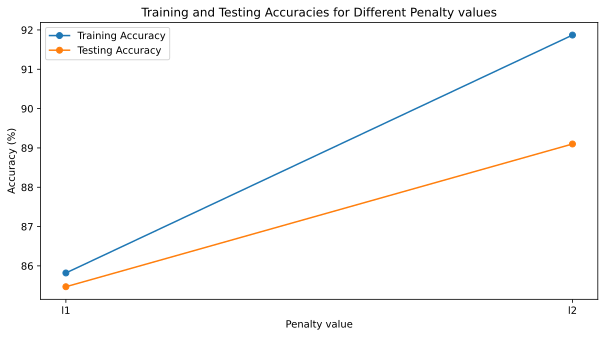

The best Penalty value is: l2 test_accuracy: 89.1


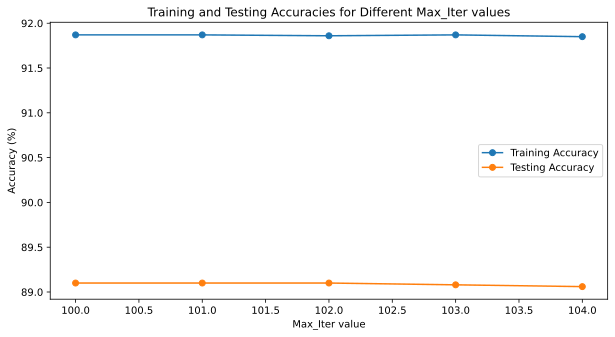

The best Max_Iter value is: 100 test_accuracy: 89.1
C=0.006, Penalty-l2, Max_Iter=100, Train Accuarcy:0.9186783450829595, Test Accuarcy:0.89104892117069
CPU times: total: 26.1 s
Wall time: 38.8 s


In [7]:
%%time
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')


def plotNprint_diff(param_list, train_accuracy_list, test_accuracy_list, param_name): 
    plt.figure(figsize=(10, 5))
    plt.plot(param_list, train_accuracy_list, marker='o', label='Training Accuracy')
    plt.plot(param_list, test_accuracy_list, marker='o', label='Testing Accuracy')
    plt.xlabel(f'{param_name} value')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Training and Testing Accuracies for Different {param_name} values')
    plt.legend()
    plt.show()
    print(f'The best {param_name} value is: {param_list[test_accuracy_list.index(max(test_accuracy_list))]} test_accuracy: {max(test_accuracy_list)}')
    return param_list[test_accuracy_list.index(max(test_accuracy_list))]

def basic_log(logReg) :
    logReg.fit(X_train, y_train)

    lgy_pred = logReg.predict(X_test)

    train_accuracy = accuracy_score(y_train, logReg.predict(X_train))
    test_accuracy = accuracy_score(y_test, lgy_pred)
    return lgy_pred, train_accuracy, test_accuracy
    
    

c_list =  [0.005, 0.006, 0.007, 0.008]
test_accuracy_list = []
train_accuracy_list = []

for c in c_list: 
    
    logReg = LogisticRegression(C=c)
    lgy_pred, train_accuracy, test_accuracy = basic_log(logReg)

    train_accuracy_list.append(round(train_accuracy*100, 2))
    test_accuracy_list.append(round(test_accuracy*100, 2))
    

best_c = plotNprint_diff(c_list, train_accuracy_list, test_accuracy_list,'C')


test_accuracy_list = []
train_accuracy_list = []

penalty_list = ['l1', 'l2']
for penalty in penalty_list:
    solver = 'liblinear'
    if penalty == 'l2' : solver = 'lbfgs'
    
    logReg = LogisticRegression(penalty=penalty, C=best_c, solver=solver)
    
    lgy_pred, train_accuracy, test_accuracy = basic_log(logReg)

    train_accuracy_list.append(round(train_accuracy*100, 2))
    test_accuracy_list.append(round(test_accuracy*100, 2))


best_penalty = plotNprint_diff(penalty_list, train_accuracy_list, test_accuracy_list,'Penalty')

test_accuracy_list = []
train_accuracy_list = []

max_iter_list = [100, 101, 102, 103, 104]
for max_iter in max_iter_list:
    solver = 'liblinear'
    if best_penalty == 'l2' : solver = 'lbfgs'
    logReg = LogisticRegression(penalty=best_penalty, C=best_c, max_iter=max_iter, solver=solver)
    
    lgy_pred, train_accuracy, test_accuracy = basic_log(logReg)

    train_accuracy_list.append(round(train_accuracy*100, 2))
    test_accuracy_list.append(round(test_accuracy*100, 2)) 

best_max_iter = plotNprint_diff(max_iter_list, train_accuracy_list, test_accuracy_list,'Max_Iter')

solver = 'liblinear'
if best_penalty == 'l2' : solver = 'lbfgs'
logReg = LogisticRegression(penalty=best_penalty, C=best_c, max_iter=best_max_iter, solver=solver)
lgy_pred, train_accuracy, test_accuracy = basic_log(logReg)
print(f'C={best_c}, Penalty-{best_penalty}, Max_Iter={best_max_iter}, Train Accuarcy:{train_accuracy}, Test Accuarcy:{test_accuracy}')
lg_test_accuracy = test_accuracy

##Plot confusion matrix

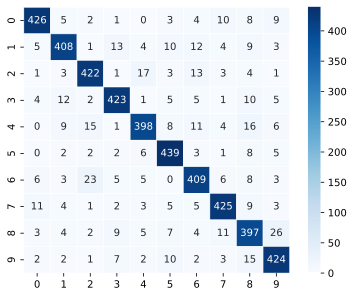

In [8]:
sns.heatmap(confusion_matrix(y_test, lgy_pred), annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');

## Plot 16 random samples from the test dataset with true labels and predicted classes

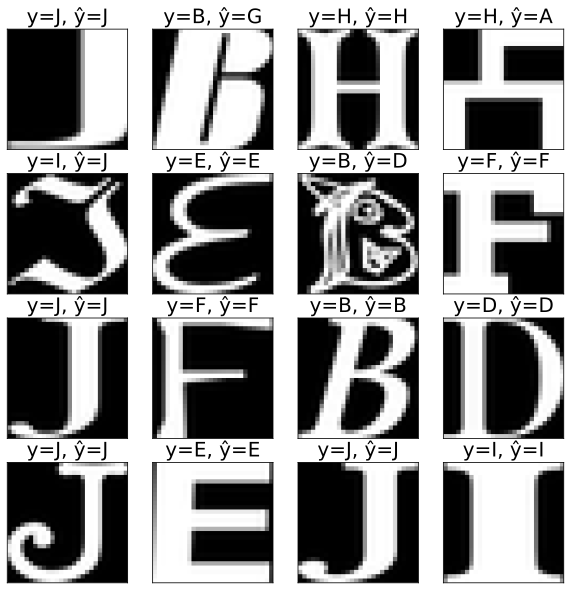

In [9]:
plot_letters(X_test, y_test, lgy_pred, n=4, random_state=16)

## kNN

**Hyperparameters**:
* `n_neigbors`
* `metric`

  File "d:\LearningML\Intro2ML\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


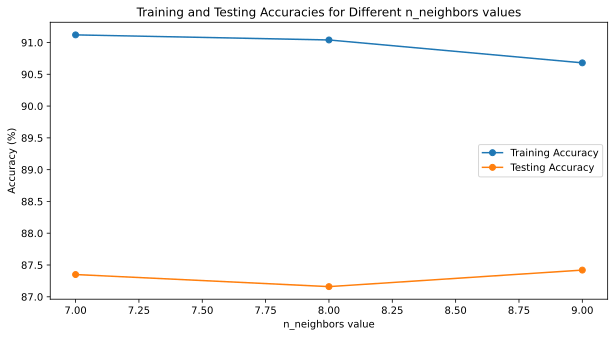

The best n_neighbors value is: 9 test_accuracy: 87.42


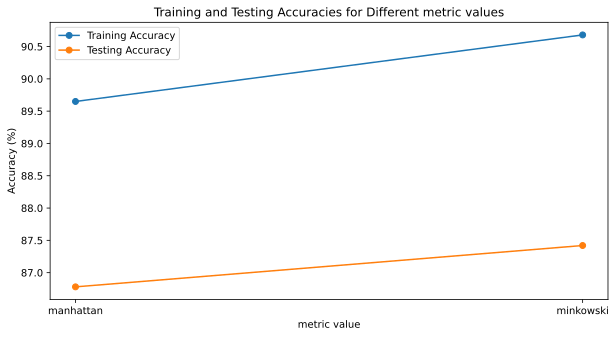

The best metric value is: minkowski test_accuracy: 87.42
N=9, Metric-minkowski, Train Accuarcy:0.9067862992238126, Test Accuarcy:0.8741721854304636
CPU times: total: 5min 6s
Wall time: 39.1 s


In [10]:
%%time
from sklearn.neighbors import KNeighborsClassifier
warnings.filterwarnings('ignore')

def basic_knn(knn) :
    knn.fit(X_train, y_train)

    knny_pred = knn.predict(X_test)

    train_accuracy = accuracy_score(y_train, knn.predict(X_train))
    test_accuracy = accuracy_score(y_test, knny_pred)
    return knny_pred, train_accuracy, test_accuracy
    

n_list = [7,8,9] 
test_accuracy_list = []
train_accuracy_list = []

for n in n_list: 
    knn = KNeighborsClassifier(n_neighbors=n)

    knny_pred, train_accuracy, test_accuracy = basic_knn(knn)
    train_accuracy_list.append(round(train_accuracy*100, 2))
    test_accuracy_list.append(round(test_accuracy*100, 2))
    
best_n = plotNprint_diff(n_list, train_accuracy_list, test_accuracy_list, 'n_neighbors')


metric_list = ['manhattan', 'minkowski']

test_accuracy_list = []
train_accuracy_list = []

for metric in metric_list: 
    knn = KNeighborsClassifier(n_neighbors=best_n, metric=metric)
    
    knny_pred, train_accuracy, test_accuracy = basic_knn(knn)

    train_accuracy_list.append(round(train_accuracy*100, 2))
    test_accuracy_list.append(round(test_accuracy*100, 2))
    
best_metric = plotNprint_diff(metric_list, train_accuracy_list, test_accuracy_list, 'metric')

knn = KNeighborsClassifier(n_neighbors=best_n, metric=best_metric)
knny_pred, train_accuracy, test_accuracy = basic_knn(knn)
print(f'N={best_n}, Metric-{best_metric}, Train Accuarcy:{train_accuracy}, Test Accuarcy:{test_accuracy}')
knn_test_accuracy = test_accuracy

##Plot confusion matrix

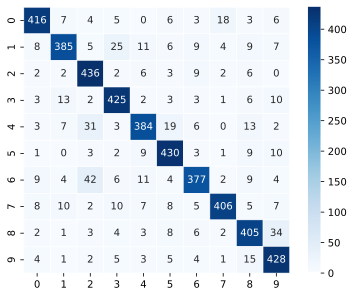

In [11]:
sns.heatmap(confusion_matrix(y_test, knny_pred), annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');

##Plot 16 random samples from the test dataset with true labels and predicted classes

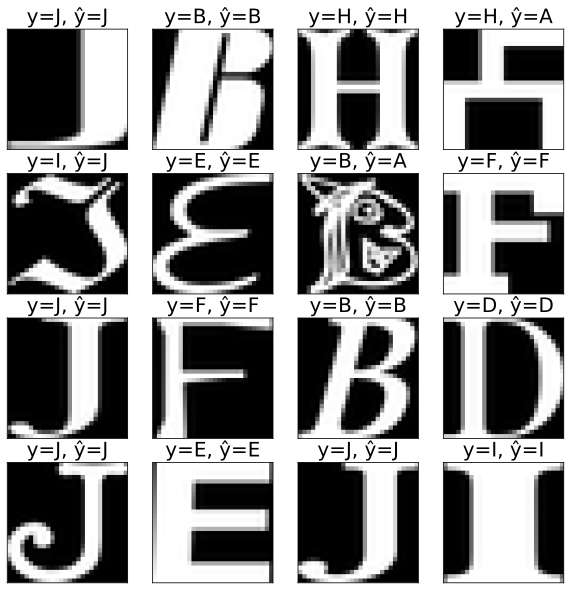

In [12]:
# Assuming X_test, y_test, and cnny_pred are defined
plot_letters(X_test, y_test, knny_pred, n=4, random_state=16)


## MLP

**Hyperparameters**:
* number of layers
* width of layers
* activation function

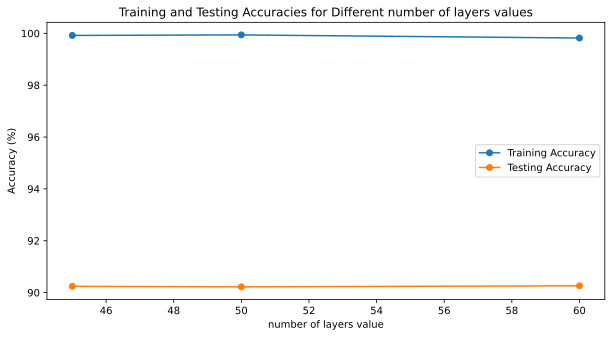

The best number of layers value is: 60 test_accuracy: 90.26


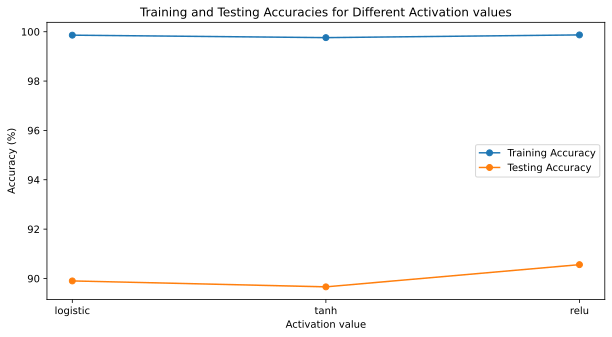

The best Activation value is: relu test_accuracy: 90.56
Layers=60, Activation-relu, Train Accuarcy:0.9991454817346721, Test Accuarcy:0.9074983977782525
CPU times: total: 39 s
Wall time: 1min 27s


In [13]:
%%time
from sklearn.neural_network import MLPClassifier

def basic_mlp(mlp) :
    mlp.fit(X_train, y_train)

    mlpy_pred = mlp.predict(X_test)

    train_accuracy = accuracy_score(y_train, mlp.predict(X_train))
    test_accuracy = accuracy_score(y_test, mlpy_pred)
    return mlpy_pred, train_accuracy, test_accuracy

layers_list = [45 , 50, 60]
test_accuracy_list = []
train_accuracy_list = [] 

for l in layers_list: 
    mlp = MLPClassifier(hidden_layer_sizes=(l,))

    mlpy_pred, train_accuracy, test_accuracy = basic_mlp(mlp)

    train_accuracy_list.append(round(train_accuracy*100, 2))
    test_accuracy_list.append(round(test_accuracy*100, 2))
    
best_num_layers = plotNprint_diff(layers_list, train_accuracy_list, test_accuracy_list, "number of layers")

activation_functions = ['logistic', 'tanh', 'relu']
test_accuracy_list = []
train_accuracy_list = [] 

for a in activation_functions :
    mlp = MLPClassifier(hidden_layer_sizes=(best_num_layers,), activation=a)
    mlpy_pred, train_accuracy, test_accuracy = basic_mlp(mlp)

    train_accuracy_list.append(round(train_accuracy*100, 2))
    test_accuracy_list.append(round(test_accuracy*100, 2))
    
best_activation = plotNprint_diff(activation_functions, train_accuracy_list, test_accuracy_list, "Activation")

mlp = MLPClassifier(hidden_layer_sizes=(best_num_layers,), activation=best_activation)

mlpy_pred, train_accuracy, test_accuracy = basic_mlp(mlp)

print(f'Layers={best_num_layers}, Activation-{best_activation}, Train Accuarcy:{train_accuracy}, Test Accuarcy:{test_accuracy}')
mlp_test_accuracy = test_accuracy


##Plot confusion matrix

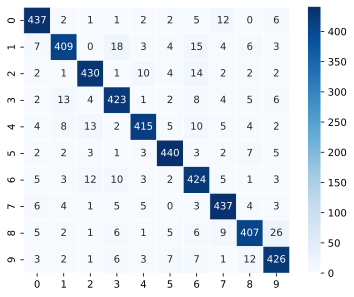

In [14]:
sns.heatmap(confusion_matrix(y_test, mlpy_pred), annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues');

##Plot 16 random samples from the test dataset with true labels and predicted classes

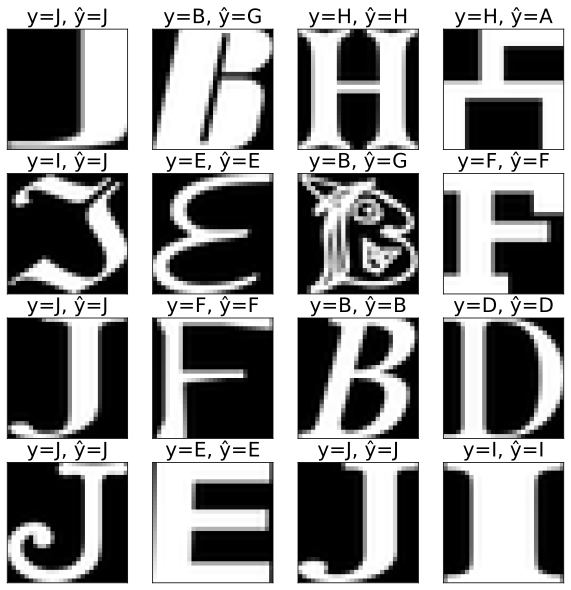

In [15]:
plot_letters(X_test, y_test, mlpy_pred, n=4, random_state=16)

## CNN

**Hyperparameters**:
* number of convolutional layers
* number of dense layers
* activation function

Epoch 1/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7307 - loss: 0.8656 - val_accuracy: 0.9025 - val_loss: 0.3265
Epoch 2/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9083 - loss: 0.3144 - val_accuracy: 0.9246 - val_loss: 0.2667
Epoch 3/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9371 - loss: 0.2080 - val_accuracy: 0.9210 - val_loss: 0.2547
Epoch 4/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9489 - loss: 0.1687 - val_accuracy: 0.9189 - val_loss: 0.2776
Epoch 5/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9590 - loss: 0.1246 - val_accuracy: 0.9196 - val_loss: 0.2744
Epoch 6/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9673 - loss: 0.1048 - val_accuracy: 0.9302 - val_loss: 0.2706
Epoch 7/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9754 - loss: 0.0747 - val_accuracy: 0.9246 - val_loss: 0.2895
Epoch 8/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9825 - loss: 0.0549 - val_accuracy: 0.

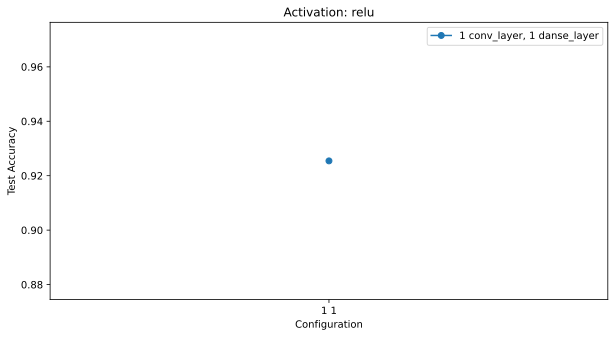

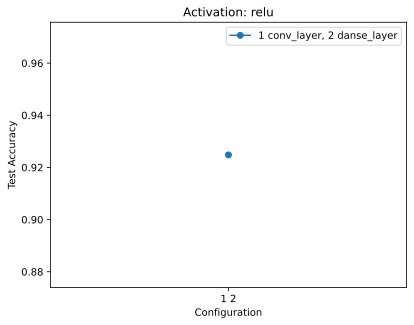

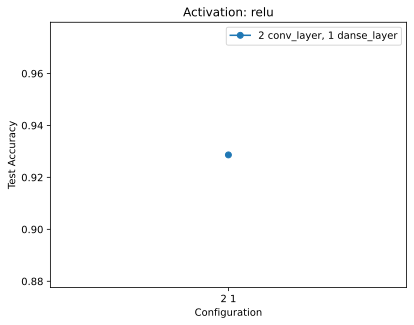

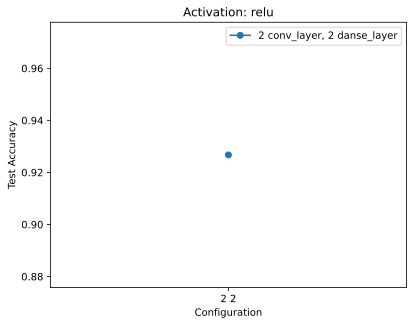

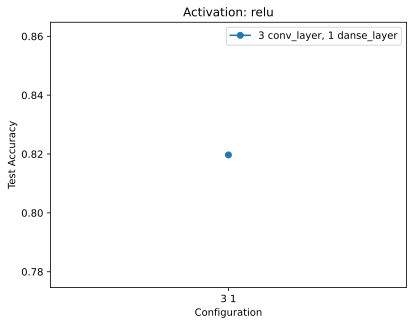

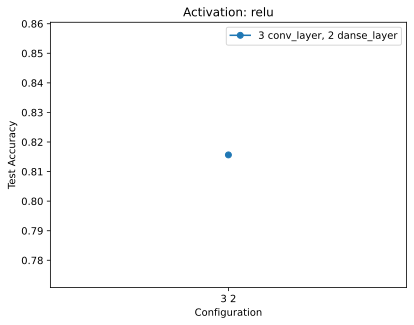

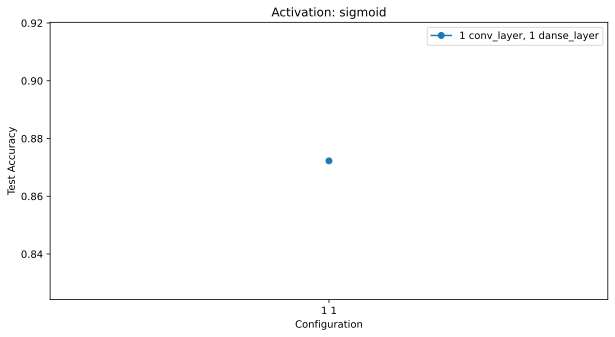

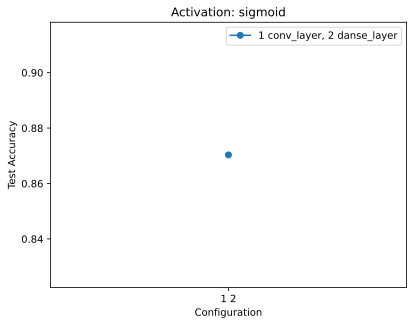

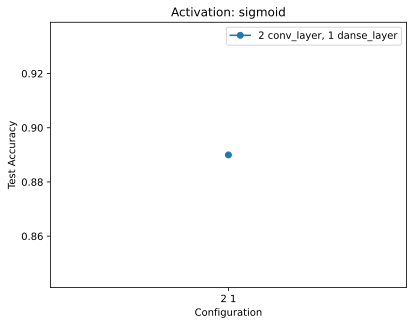

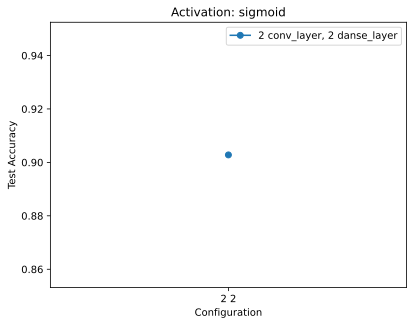

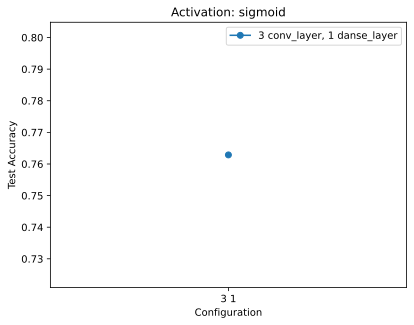

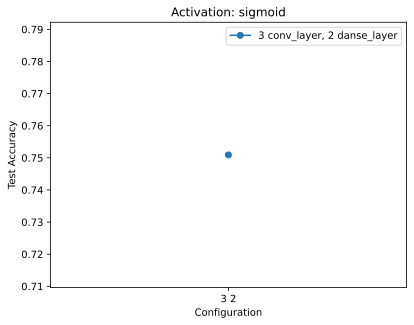

CPU times: total: 2min 3s
Wall time: 4min 3s


In [24]:
%%time
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.utils import to_categorical

def basic_cnn(n_conv_layers=2, n_dense_layers=1, activation='relu', input_shape=(28, 28, 1)):
    cnn = Sequential()
    cnn.add(Conv2D(filters=32, kernel_size=(3,3), activation=activation, input_shape=input_shape))
    cnn.add(MaxPooling2D(pool_size=(2,2)))
    
    for i in range(1, n_conv_layers):
        cnn.add(Conv2D(filters=32*(2**i), kernel_size=(3,3), activation=activation))
        cnn.add(MaxPooling2D(pool_size=(2,2)))
    
    cnn.add(Flatten())
    
    for i in range(n_dense_layers):
        cnn.add(Dense(units=128, activation=activation))
    
    cnn.add(Dense(units=10, activation='softmax'))
    cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return cnn

cnn = basic_cnn()

X_train = X_train.reshape(-1,28,28,1)

X_test = X_test.reshape(-1,28,28,1)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)  

training = cnn.fit(X_train, y_train, epochs=10, validation_split=0.1)

train_loss, train_accuracy = cnn.evaluate(X_train, y_train, verbose=2)

test_loss, cnn_test_accuracy = cnn.evaluate(X_test, y_test, verbose=2)

print(f'Train accuracy: {train_accuracy*100:.2f}%')

print(f'Test accuracy: {cnn_test_accuracy*100:.2f}%')

cnny_pred = cnn.predict(X_test)
cnny_pred_classes = cnny_pred.argmax(axis=-1)

n_c_l_list = [1, 2, 3]
n_d_l_list = [1, 2]
activation_functions = ['relu', 'sigmoid']

answers = []

for n_c in n_c_l_list:
    for n_d in n_d_l_list:
        for a in activation_functions:
            cnn = basic_cnn(n_conv_layers=n_c, n_dense_layers=n_d, activation=a)
            cnn.fit(X_train, y_train, epochs=5, verbose=0)
            test_loss, test_accuracy =cnn.evaluate(X_test, y_test, verbose=0)
            answers.append((n_c, n_d, a, test_accuracy))
        
for a in activation_functions:
    plt.figure(figsize=(10, 5))
    for ans in answers:
        if ans[2] == a:
            plt.plot(f'{ans[0]} {ans[1]}', ans[3], marker='o', label=f'{ans[0]} conv_layer, {ans[1]} danse_layer')
            plt.title(f'Activation: {a}')
            plt.xlabel('Configuration')
            plt.ylabel('Test Accuracy')
            plt.legend()
            plt.show()
        


Plot confusion matrix

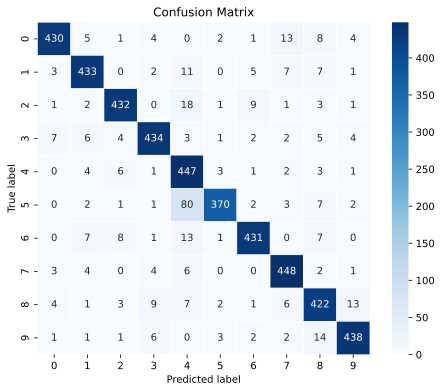

In [26]:
cm = confusion_matrix(y_test.argmax(axis=1), cnny_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

##Plot 16 random samples from the test dataset with true labels and predicted classes

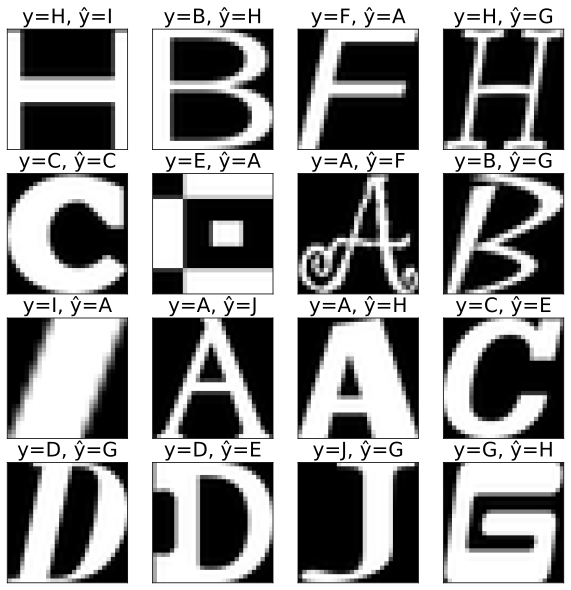

In [22]:
plot_letters(X_test, y_test, cnny_pred_classes)

## Plot results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


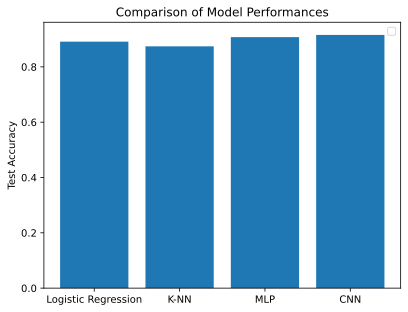

In [27]:
accuracies = [lg_test_accuracy, knn_test_accuracy, mlp_test_accuracy, cnn_test_accuracy]

models = ['Logistic Regression', 'K-NN', 'MLP', 'CNN']

plt.bar(models, accuracies)
plt.ylabel('Test Accuracy')
plt.title('Comparison of Model Performances')
plt.legend()
plt.show()